In [2]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import random
import matplotlib.pyplot as plt
from psychopy import visual, event, core
import cv2 

In [46]:
def ShowImage(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off') 
    plt.show()


def PiImage(ori = None):
    size, fixed_length, diff, leg_width, bar_height = 128, 80, 20, 1, 2
    Pi = np.zeros((size, size)) 

    spacing = size // 3
    left_x = spacing
    right_x = size - spacing 

    bar_y = int(size * 1/4) 

    if ori == 'right':
        left_len = fixed_length
        right_len = fixed_length + diff
    elif ori == 'left':
        right_len = fixed_length
        left_len = fixed_length + diff

    Pi[bar_y:bar_y + left_len // 2, left_x:left_x + leg_width] = 1
    Pi[bar_y:bar_y + right_len // 2, right_x:right_x + leg_width] = 1

    bar_y1 = bar_y - bar_height // 2
    bar_y2 = bar_y + bar_height // 2
    Pi[bar_y1:bar_y2, left_x + leg_width:right_x] = 1
            
    return Pi.astype(np.float32)

def PiMask(size=128, num_shapes=10):
    mask = np.zeros((size, size), dtype=np.uint8)
    spacing = size // 3
    left_x = spacing
    right_x = size - spacing 
    for _ in range(num_shapes):
        for x_base in [left_x, right_x]:
            x = x_base + np.random.randint(-5, 5)
            y1 = np.random.randint(20, size - 20)
            y2 = y1 + np.random.randint(5, 20)
            cv2.line(mask, (x, y1), (x, y2), 255, thickness=1)

        x1 = np.random.randint(left_x, right_x)
        y = np.random.randint(size // 6, size // 4)
        angle = np.random.choice([-1, 1]) * np.random.randint(5, 15)
        x2 = x1 + angle
        y2 = y + np.random.randint(5, 15)
        cv2.line(mask, (x1, y), (x2, y2), 255, thickness=1)
        
    return (mask / 255).astype(np.float32)

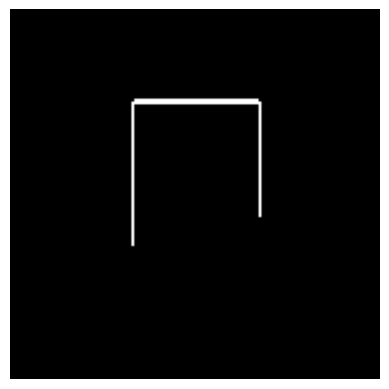

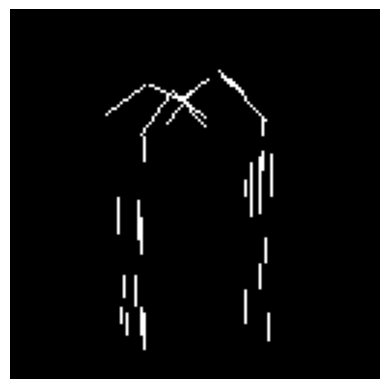

In [48]:
ShowImage(PiImage(ori = 'left'))
ShowImage(PiMask())

Experiment aborted by user.
3458.3160 	WARNING 	Monitor specification not found. Creating a temporary one...


ValueError: x and y must have same first dimension, but have shapes (50,) and (8,)

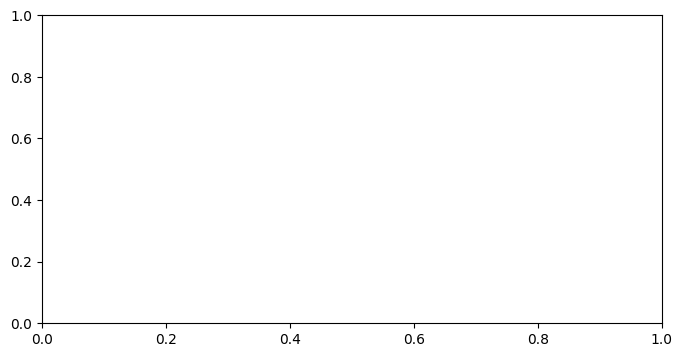

In [60]:
def Norm(image):
    return 2 * image - 1

# Visual Setup
win = visual.Window(size=(512, 512), color=-1, units="pix", fullscr=False)
stim = visual.ImageStim(win, size=(512, 512), units="pix")

# Parameters
oris = ['left', 'right']
soa = 0.05
step_size = 0.005
n_trials = 50
noise_gap = 0.3
correct_counter = 0
data = []

# Instructions Screen
instruction = visual.TextStim(win, text="Press SPACE to begin the task.\nIdentify which leg is longer using x (left) amd m (right).", color=1.0, height=24)
instruction.draw()
win.flip()

# Wait for spacebar to begin
event.waitKeys(keyList=['space'])
win.flip()


# Trial Loop
for trial in range(n_trials):
    if 'escape' in event.getKeys():
        print("Experiment aborted by user.")
        break

    fixation = visual.TextStim(win, text="+", color=1.0, height=48)
    fixation.draw()
    win.flip()
    core.wait(0.5)
    ori = random.choice(oris)
    stim.image = np.flipud(Norm(PiImage(ori = ori)))
    stim.draw()
    win.flip()
    core.wait(soa)
    stim.image = np.flipud(Norm(PiMask()))
    stim.draw()
    win.flip()
    core.wait(noise_gap)
    win.flip()
    
    keys = event.waitKeys(keyList=['x','m'] + ['escape'])
    if 'escape' in keys:
        print("Experiment aborted by user.")
        break

    response = 'left' if keys[0] == 'x' else 'right'
    correct = response == ori
    data.append({"trial": trial+1, "orientation": ori, "response": response,
                 "correct": correct, "soa": soa})
    if correct:
        correct_counter += 1
        if correct_counter == 2:
            soa = max(0, soa - step_size)
            correct_counter = 0
    else:
        soa = min(1.0, soa + step_size)
        correct_counter = 0

# Cleanup 
win.close()

# ---------- Plot ----------
soas = [d["soa"] for d in data]
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_trials + 1), soas, marker='o')
plt.xlabel("Trial")
plt.ylabel("Alpha (Visibility)")
plt.title("2-Down-1-Up Staircase")
plt.grid(True)
plt.show()

# Optional: save data
import pandas as pd
df = pd.DataFrame(data)
df.to_csv("Results.csv", index=False)